##**Import Libraries**

In [1]:
# 1. General Libraries & Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices)) 

# Paths and constants
BASE_DIR = 'data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')
VAL_CSV = os.path.join(BASE_DIR, 'valid.csv')
TEST_CSV = os.path.join(BASE_DIR, 'test.csv')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42 

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow version: 2.15.0
Num GPUs Available: 1


Train class distribution:
diagnosis
0    1444
2     799
1     296
4     236
3     154
Name: count, dtype: int64


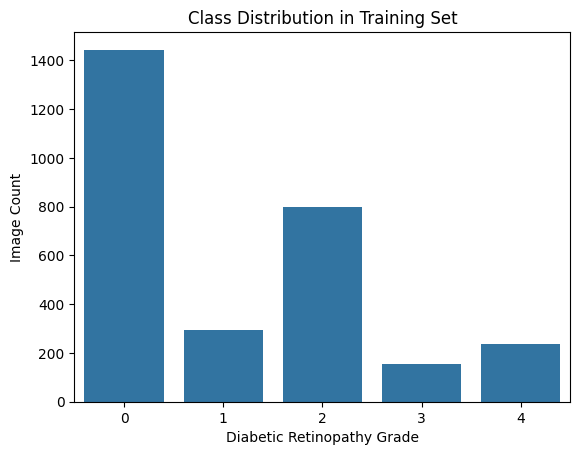

In [2]:
# 2. Load CSVs and EDA

train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

print("Train class distribution:")
print(train_df['diagnosis'].value_counts())

sns.countplot(data=train_df, x='diagnosis')
plt.title("Class Distribution in Training Set")
plt.xlabel("Diabetic Retinopathy Grade")
plt.ylabel("Image Count")
plt.show()

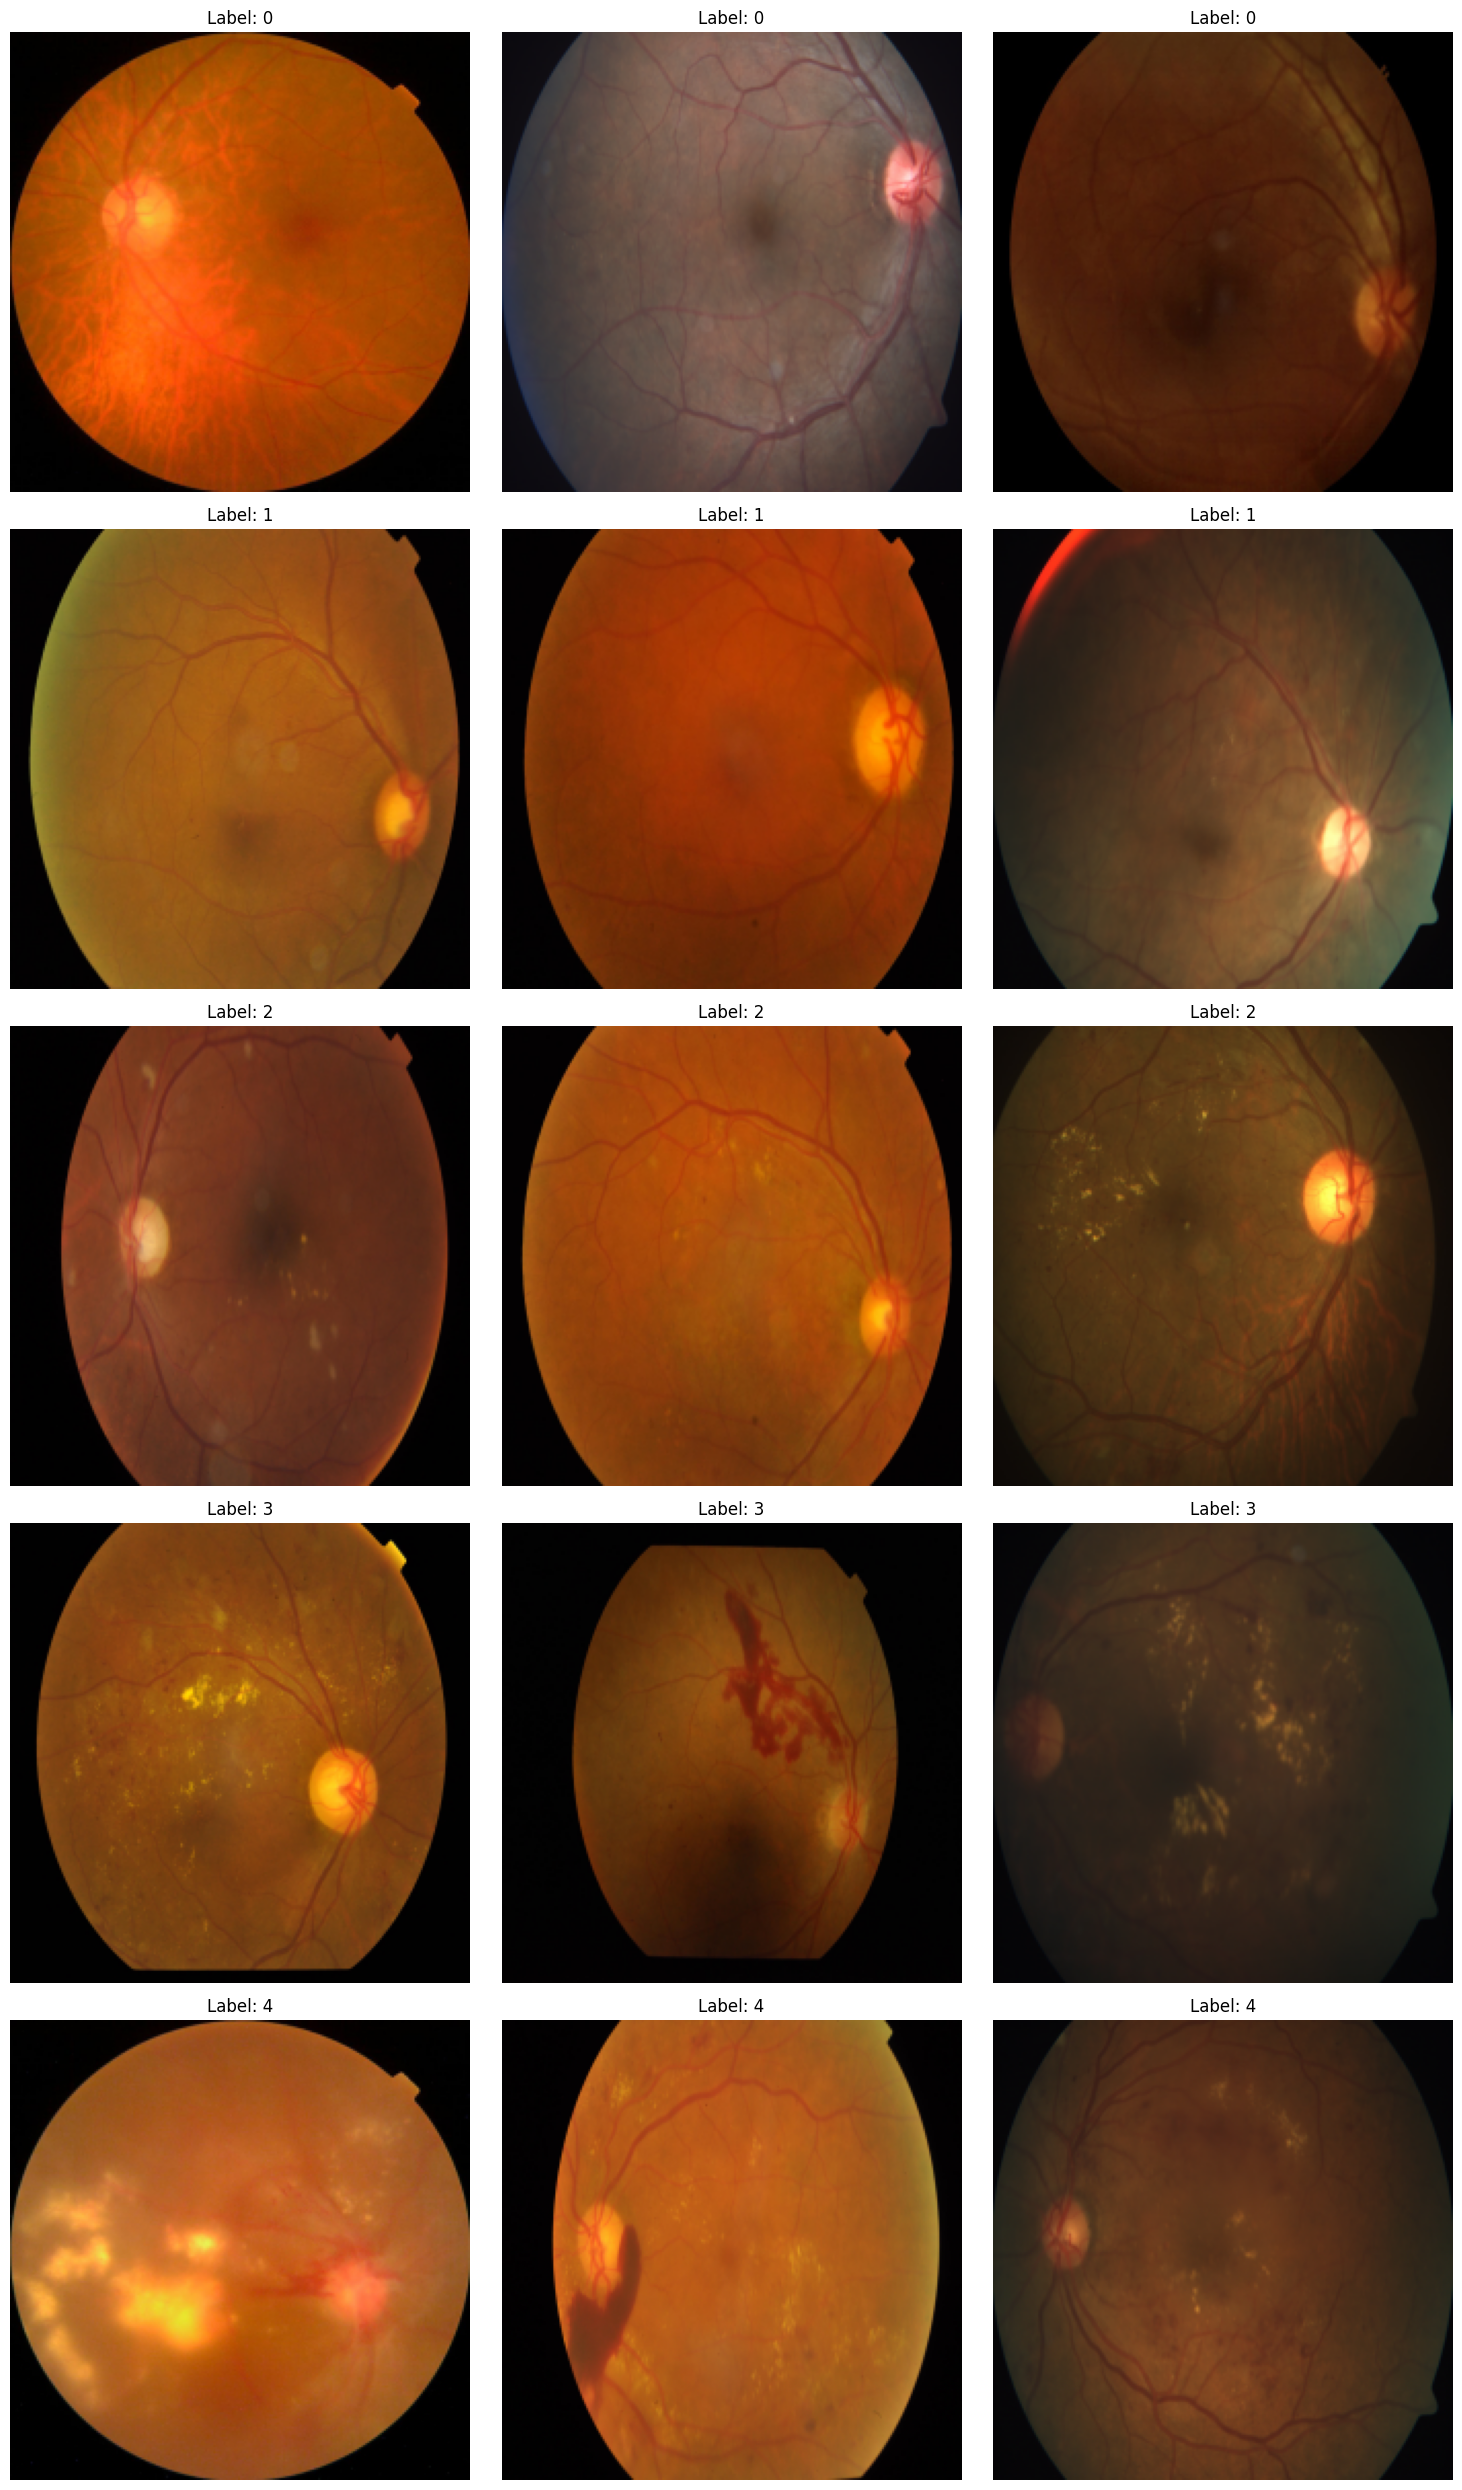

In [3]:
# 3. Visualize Sample Images per Class

def show_sample_images(df, directory, label_col='diagnosis', image_col='id_code', samples_per_class=3):
    labels = sorted(df[label_col].unique())
    plt.figure(figsize=(15, 5 * len(labels)))

    for class_idx, label in enumerate(labels):
        sample_paths = df[df[label_col] == label].sample(samples_per_class, random_state=SEED)
        for i, (_, row) in enumerate(sample_paths.iterrows()):
            img_path = os.path.join(directory, f"{row[image_col]}.png")
            img = Image.open(img_path)
            plt.subplot(len(labels), samples_per_class, class_idx * samples_per_class + i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Label: {label}')
    
    plt.tight_layout()
    plt.show()

show_sample_images(train_df, TRAIN_DIR)

In [4]:
# 4. Inspect one image shape

sample_img_path = os.path.join(TRAIN_DIR, train_df.iloc[0]['id_code'] + ".png")
sample_img = Image.open(sample_img_path)
print("Image size:", sample_img.size)
print("Image mode:", sample_img.mode)

Image size: (224, 224)
Image mode: RGB


In [5]:
# Inspect one image shape
sample_img_path = os.path.join(TRAIN_DIR, train_df.iloc[0]['id_code'] + ".png")
sample_img = Image.open(sample_img_path)
print("Image size:", sample_img.size)
print("Image mode:", sample_img.mode)

Image size: (224, 224)
Image mode: RGB


In [6]:
# 5. Define ImageDataGenerators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# 6. Add full file paths & convert labels to string for generators

train_df['file_path'] = train_df['id_code'].apply(lambda x: os.path.join(TRAIN_DIR, f"{x}.png"))
val_df['file_path'] = val_df['id_code'].apply(lambda x: os.path.join(VAL_DIR, f"{x}.png"))

train_df['diagnosis'] = train_df['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)

In [8]:
# 7. Balance training data with oversampling minority classes

from sklearn.utils import resample

df_majority = train_df[train_df['diagnosis'] == "0"]
df_minority = train_df[train_df['diagnosis'] != "0"]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=SEED)

train_df_balanced = pd.concat([df_majority, df_minority_upsampled])
train_df_balanced = train_df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Convert diagnosis to string again (ensure correct type)
train_df_balanced['diagnosis'] = train_df_balanced['diagnosis'].astype(str)

In [9]:
# 8. Create data generators with balanced data

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col='file_path',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2888 validated image filenames belonging to 5 classes.
Found 366 validated image filenames belonging to 5 classes.


In [10]:
# 9. Compute class weights (convert diagnosis to int temporarily)

from sklearn.utils.class_weight import compute_class_weight

train_df_int = train_df.copy()
train_df_int['diagnosis'] = train_df_int['diagnosis'].astype(int)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df_int['diagnosis']),
    y=train_df_int['diagnosis']
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 0.4056786703601108, 1: 1.979054054054054, 2: 0.7331664580725907, 3: 3.803896103896104, 4: 2.4822033898305085}


In [11]:
# 10. Import model and training utilities, define CBAM modules

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D, Multiply, Add, Activation, GlobalAveragePooling2D, Reshape
from tensorflow.keras.optimizers import Adam 
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# CBAM implementation

def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    shared_layer_one = Dense(channel // ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = tf.reduce_max(input_feature, axis=[1,2], keepdims=True)
    max_pool = Reshape((1,1,channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    
    return Multiply()([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    avg_pool = tf.reduce_mean(input_feature, axis=3, keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=3, keepdims=True)
    concat = tf.concat([avg_pool, max_pool], axis=3)
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    
    return Multiply()([input_feature, cbam_feature])

def cbam_block(cbam_feature, ratio=8):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [12]:
# 11. Build ResNet50 + CBAM model with multi-stage attention

input_tensor = Input(shape=(*IMG_SIZE, 3))

# Load ResNet50 without top
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Access intermediate layers after each major block for attention
layer_names = [
    'conv2_block3_out',  # Stage 1 output
    'conv3_block4_out',  # Stage 2 output
    'conv4_block6_out',  # Stage 3 output
    'conv5_block3_out'   # Stage 4 output (final conv block)
]

x = input_tensor
for layer_name in layer_names:
    x = base_model.get_layer(layer_name).output if layer_name == layer_names[0] else x
    # Apply CBAM on output of this stage
    x = cbam_block(x)
    # For next stage get the output from base model accordingly
    if layer_name != layer_names[-1]:
        next_layer = base_model.get_layer(layer_names[layer_names.index(layer_name)+1])
        x = next_layer.output

# After last CBAM, apply pooling and classification head
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Make base_model layers trainable for fine-tuning
base_model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2025-07-03 11:41:37.982950: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-07-03 11:41:37.982974: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-07-03 11:41:37.982979: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-07-03 11:41:37.983003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-03 11:41:37.983015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [13]:
# 12. Setup callbacks

checkpoint_cb = ModelCheckpoint("models/best_model_cbam.h5", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [14]:
# 13. Define Macro F1 callback for validation metric

from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np

class MacroF1Callback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator):
        super().__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_trues = []
        for i in range(len(self.val_generator)):
            x_val, y_val = self.val_generator[i]
            preds = self.model.predict(x_val)
            val_preds.extend(np.argmax(preds, axis=1))
            val_trues.extend(np.argmax(y_val, axis=1))
        f1 = f1_score(val_trues, val_preds, average='macro')
        print(f"\nEpoch {epoch+1} Macro F1: {f1:.4f}")

In [15]:
# 14. Train the model with class weights and callbacks

EPOCHS = 30
macro_f1_cb = MacroF1Callback(val_generator)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint_cb, reduce_lr_cb, macro_f1_cb]
)

Epoch 1/30


2025-07-03 11:41:43.598309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-03 11:41:44.226425: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


91/91 [==============================] - ETA: 0s - loss: 1.3719 - accuracy: 0.5512

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 631ms/step

Epoch 1 Macro F1: 0.0294
91/91 [==============================] - 52s 510ms/step - loss: 1.3719 - accuracy: 0.5512 - val_loss: 1.7062 - val_accuracy: 0.0792 - lr: 1.0000e-04
Epoch 2/30
1/1 [==============================] - 0s 70ms/step

Epoch 2 Macro F1: 0.0367
91/91 [==============================] - 44s 480ms/step - loss: 0.9944 - accuracy: 0.6887 - val_loss: 2.1890 - val_accuracy: 0.1011 - lr: 1.0000e-04
Epoch 3/30
91/91 [==============================] - ETA: 0s - loss: 0.8294 - accuracy: 0.7389

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 70ms/step

Epoch 3 Macro F1: 0.1392
91/91 [==============================] - 44s 487ms/step - loss: 0.8294 - accuracy: 0.7389 - val_loss: 1.5951 - val_accuracy: 0.4809 - lr: 1.0000e-04
Epoch 4/30
91/91 [==============================] - ETA: 0s - loss: 0.7286 - accuracy: 0.7857

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 69ms/step

Epoch 4 Macro F1: 0.1319
91/91 [==============================] - 44s 480ms/step - loss: 0.7286 - accuracy: 0.7857 - val_loss: 1.5884 - val_accuracy: 0.4918 - lr: 1.0000e-04
Epoch 5/30
91/91 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.8130

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 67ms/step

Epoch 5 Macro F1: 0.1631
91/91 [==============================] - 44s 484ms/step - loss: 0.6436 - accuracy: 0.8130 - val_loss: 1.3768 - val_accuracy: 0.4645 - lr: 1.0000e-04
Epoch 6/30
1/1 [==============================] - 0s 68ms/step

Epoch 6 Macro F1: 0.0512
91/91 [==============================] - 43s 476ms/step - loss: 0.5682 - accuracy: 0.8293 - val_loss: 2.6592 - val_accuracy: 0.1175 - lr: 1.0000e-04
Epoch 7/30
91/91 [==============================] - ETA: 0s - loss: 0.5158 - accuracy: 0.8476

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 68ms/step

Epoch 7 Macro F1: 0.3120
91/91 [==============================] - 44s 481ms/step - loss: 0.5158 - accuracy: 0.8476 - val_loss: 1.1312 - val_accuracy: 0.5437 - lr: 1.0000e-04
Epoch 8/30
1/1 [==============================] - 0s 68ms/step

Epoch 8 Macro F1: 0.3914
91/91 [==============================] - 44s 479ms/step - loss: 0.4112 - accuracy: 0.8767 - val_loss: 1.2392 - val_accuracy: 0.6038 - lr: 1.0000e-04
Epoch 9/30
1/1 [==============================] - 0s 68ms/step

Epoch 9 Macro F1: 0.2926
91/91 [==============================] - 44s 479ms/step - loss: 0.3692 - accuracy: 0.8913 - val_loss: 1.8703 - val_accuracy: 0.5137 - lr: 1.0000e-04
Epoch 10/30
1/1 [==============================] - 0s 68ms/step

Epoch 10 Macro F1: 0.3588
91/91 [==============================] - 44s 479ms/step - loss: 0.3684 - accuracy: 0.8830 - val_loss: 1.4435 - val_accuracy: 0.5574 - lr: 1.0000e-04
Epoch 11/30
91/91 [==============================] - ETA:

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 69ms/step

Epoch 11 Macro F1: 0.4050
91/91 [==============================] - 44s 483ms/step - loss: 0.2579 - accuracy: 0.9221 - val_loss: 1.0894 - val_accuracy: 0.6639 - lr: 2.0000e-05
Epoch 12/30
91/91 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9391

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 69ms/step

Epoch 12 Macro F1: 0.4501
91/91 [==============================] - 45s 487ms/step - loss: 0.2075 - accuracy: 0.9391 - val_loss: 1.0285 - val_accuracy: 0.6885 - lr: 2.0000e-05
Epoch 13/30
91/91 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9505

/Users/nikhilgiji/Drive/cs/computer_vision/RetinoGrade/retino/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 72ms/step

Epoch 13 Macro F1: 0.5150
91/91 [==============================] - 44s 485ms/step - loss: 0.1819 - accuracy: 0.9505 - val_loss: 0.8981 - val_accuracy: 0.7459 - lr: 2.0000e-05
Epoch 14/30
1/1 [==============================] - 0s 68ms/step

Epoch 14 Macro F1: 0.5643
91/91 [==============================] - 44s 479ms/step - loss: 0.1748 - accuracy: 0.9491 - val_loss: 0.9207 - val_accuracy: 0.7650 - lr: 2.0000e-05
Epoch 15/30
1/1 [==============================] - 0s 68ms/step

Epoch 15 Macro F1: 0.5470
91/91 [==============================] - 44s 478ms/step - loss: 0.1264 - accuracy: 0.9619 - val_loss: 0.9310 - val_accuracy: 0.7623 - lr: 2.0000e-05
Epoch 16/30
1/1 [==============================] - 0s 68ms/step

Epoch 16 Macro F1: 0.5566
91/91 [==============================] - 44s 478ms/step - loss: 0.1305 - accuracy: 0.9616 - val_loss: 1.0318 - val_accuracy: 0.7623 - lr: 2.0000e-05
Epoch 17/30
1/1 [==============================] - 0

12/12 [==============================] - 2s 120ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       180
           1       0.42      0.54      0.47        37
           2       0.69      0.70      0.70       100
           3       0.22      0.10      0.14        20
           4       0.41      0.38      0.39        29

    accuracy                           0.76       366
   macro avg       0.54      0.54      0.53       366
weighted avg       0.75      0.76      0.75       366



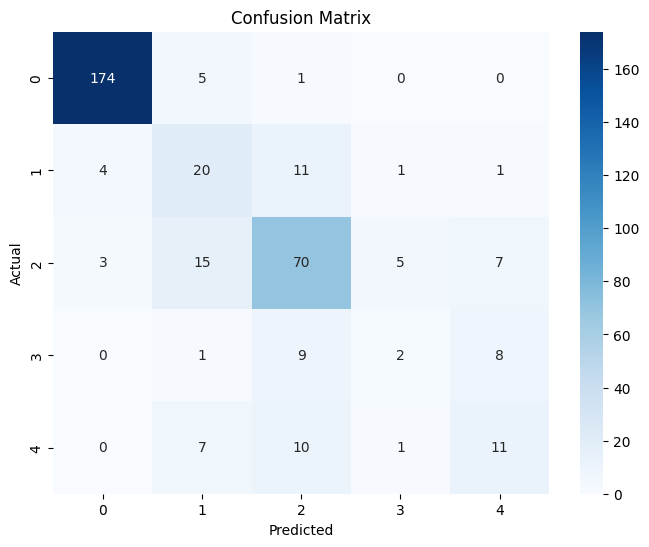

In [21]:
# 15. Validation evaluation: classification report & confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

print(classification_report(y_true, y_pred, target_names=list(val_generator.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=val_generator.class_indices.keys(), 
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('outputs/confusion_matrix.png')
plt.show()

In [22]:
# 16. Validation metrics: balanced accuracy, macro F1, AUC per class

from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy: {bal_acc:.4f}")

macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1-score: {macro_f1:.4f}")

try:
    aucs = []
    for i in range(5):
        auc = roc_auc_score((y_true == i).astype(int), preds[:, i])
        aucs.append(auc)
        print(f"AUC for class {i}: {auc:.4f}")
    print(f"Mean AUC: {np.mean(aucs):.4f}")
except Exception as e:
    print("Error calculating AUC:", e)

Balanced Accuracy: 0.5373
Macro F1-score: 0.5324
Error calculating AUC: 'bool' object has no attribute 'astype'


In [23]:
# 17. Threshold tuning on validation predictions (optional)

def apply_thresholds(probs, thresholds):
    preds = np.zeros_like(probs)
    for i, thr in enumerate(thresholds):
        preds[:, i] = (probs[:, i] >= thr).astype(int)
    return preds

thresholds = [0.5] * 5

pred_binary = apply_thresholds(preds, thresholds)

final_preds = []
for i in range(len(pred_binary)):
    if pred_binary[i].sum() == 0:
        final_preds.append(0)
    elif pred_binary[i].sum() == 1:
        final_preds.append(np.argmax(pred_binary[i]))
    else:
        candidates = np.where(pred_binary[i] == 1)[0]
        best = candidates[np.argmax(preds[i][candidates])]
        final_preds.append(best)

final_preds = np.array(final_preds)

from sklearn.metrics import classification_report

print(classification_report(y_true, final_preds, target_names=list(val_generator.class_indices.keys())))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       180
           1       0.40      0.51      0.45        37
           2       0.71      0.70      0.70       100
           3       0.22      0.10      0.14        20
           4       0.38      0.34      0.36        29

    accuracy                           0.75       366
   macro avg       0.53      0.53      0.52       366
weighted avg       0.74      0.75      0.74       366



12/12 [==============================] - 2s 118ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       180
           1       0.42      0.54      0.47        37
           2       0.69      0.70      0.70       100
           3       0.22      0.10      0.14        20
           4       0.41      0.38      0.39        29

    accuracy                           0.76       366
   macro avg       0.54      0.54      0.53       366
weighted avg       0.75      0.76      0.75       366



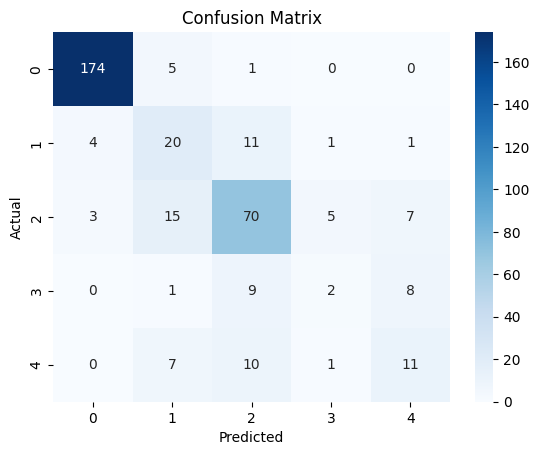

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions on validation data
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig('outputs/confusion_matrix.png')
plt.show()

Found 367 validated image filenames belonging to 5 classes.
12/12 [==============================] - 2s 121ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       181
           1       0.59      0.62      0.61        37
           2       0.76      0.76      0.76       100
           3       0.33      0.32      0.32        19
           4       0.61      0.57      0.59        30

    accuracy                           0.82       367
   macro avg       0.65      0.65      0.65       367
weighted avg       0.82      0.82      0.82       367



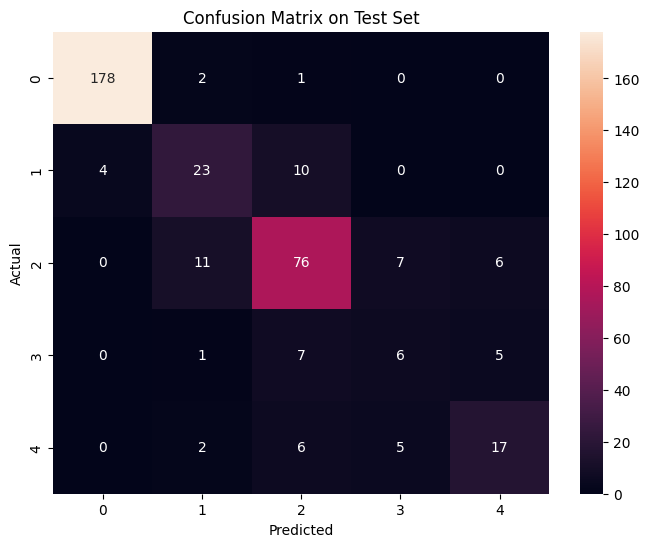

In [25]:
# 18. Test data inference (using model in memory)

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_df = pd.read_csv(TEST_CSV)
test_df['file_path'] = test_df['id_code'].apply(lambda x: os.path.join(TEST_DIR, f"{x}.png"))

if 'diagnosis' in test_df.columns:
    test_df['diagnosis'] = test_df['diagnosis'].astype(str)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='diagnosis' if 'diagnosis' in test_df.columns else None,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' if 'diagnosis' in test_df.columns else None,
    shuffle=False
)

test_generator.reset()
pred_probs = model.predict(test_generator, verbose=1)
pred_classes = pred_probs.argmax(axis=1)

class_indices = test_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
pred_labels = [inv_class_indices[i] for i in pred_classes]

if 'diagnosis' in test_df.columns:
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    y_true = test_generator.classes
    print(classification_report(y_true, pred_classes, target_names=list(class_indices.keys())))

    cm = confusion_matrix(y_true, pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix on Test Set")
    plt.savefig('outputs/confusion_matrix.png')
    plt.show()

test_df['predicted_label'] = pred_labels
test_df[['id_code', 'predicted_label']].to_csv('outputs/test_predictions_cbam.csv', index=False)